# Imports

In [1]:
import concurrent.futures
import itertools
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from scipy import stats

In [2]:
DEBUG = "CI" not in os.environ

In [3]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

In [4]:
import proteinsolver

# Parameters

In [5]:
NOTEBOOK_NAME = "global_analysis_of_protein_folding"

In [6]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/working/deep-csp-solver/notebooks/global_analysis_of_protein_folding')

In [7]:
INPUT_PATH = Path(os.getenv("DATAPKG_INPUT_DIR"))
INPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg_input_dir')

In [8]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/strokach/working/deep-csp-solver/notebooks/global_analysis_of_protein_folding')

In [9]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("CI_COMMIT_SHA")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT, NETWORK_NAME

(None, None, None)

# Load data

In [10]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding

aan0693_designed-PDB-files	   aan0693_SI_datasets.tar.gz.zip  swissmodel
aan0693_designed-PDB-files.gz.zip  hhpred
aan0693_SI_datasets		   hhpred2


In [11]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_designed-PDB-files

aan0693_designed-PDB-files.gz  nmr  other  other2  rd1	rd2  rd3  rd4


In [12]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets

counts_and_ec50s.tar.gz		  protein_and_dna_sequences.tar.gz
design_scripts.tgz		  stability_scores
design_structural_metrics	  stability_scores.tar.gz
design_structural_metrics.tar.gz  unfolded_state_model_params
fig1_thermodynamic_data.csv


## aan0693_SI_datasets

In [13]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets/stability_scores

rd1_stability_scores  rd3_stability_scores  ssm2_stability_scores
rd2_stability_scores  rd4_stability_scores


In [14]:
def remove_controls(df):
    df = df[
        (~df["name"].str.endswith("_hp")) & (~df["name"].str.endswith("_random")) & (~df["name"].str.endswith("_buryD"))
    ]
    return df

In [15]:
def load_stability_scores(key):
    stability_scores = pd.read_csv(
        INPUT_PATH
        / "global_analysis_of_protein_folding"
        / "aan0693_SI_datasets"
        / "stability_scores"
        / f"{key}_stability_scores",
        sep="\t",
    )
    stability_scores = remove_controls(stability_scores)

    for energy_function in ["talaris2013", "betanov15"]:
        rosetta_energies_file = (
            INPUT_PATH
            / "global_analysis_of_protein_folding"
            / "aan0693_SI_datasets"
            / "design_structural_metrics"
            / f"{key}_relax_scored_{'filtered_' if energy_function == 'betanov15' else ''}{energy_function}.sc"
        )
        if not rosetta_energies_file.is_file():
            print(f"Not loading Rosetta energies for {energy_function}!")
            continue

        before_ = len(stability_scores)
        relax_scored_filtered = pd.read_csv(
            rosetta_energies_file, sep="\t" if energy_function == "betanov15" else " +", engine="python"
        ).rename(columns={"description": "name", "total_score": f"{energy_function}_score"})
        stability_scores = stability_scores.merge(
            relax_scored_filtered[["name", f"{energy_function}_score"]], on="name", how="outer"
        )
#         assert len(stability_scores) == before_, (len(stability_scores), before_)

    stability_scores["library_name"] = key
    return stability_scores

### stability_scores

In [16]:
# stability_scores = {}

In [17]:
# for key in ["rd1", "rd2", "rd3", "rd4", "ssm2"]:
#     stability_scores[key] = load_stability_scores(key)

In [18]:
# stability_scores["fig1"] = pd.read_csv(
#     INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_SI_datasets" / "fig1_thermodynamic_data.csv"
# ).assign(library_name="fig1")

In [19]:
stability_scores = torch.load(NOTEBOOK_PATH.joinpath("stability_scores.torch"))

# Load network

In [20]:
device = torch.device("cuda:0")
# device = "cpu"

batch_size = 4
num_features = 20
adj_input_size = 2
hidden_size = 128

In [21]:
net = proteinsolver.models.ProteinNet(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load("protein_4xEdgeConv_bs4/e12-s1652709-d6610836.state"))
net.eval()
net = net.to(device)

# Structure probabilities

In [22]:
structure_file = "/home/kimlab1/database_data/datapkg_input_dir/global_analysis_of_protein_folding/aan0693_designed-PDB-files/rd1/EEHEE_rd1_0004.pdb"

In [23]:
pdata = proteinsolver.utils.extract_seq_and_adj(structure_file, 'A')

In [24]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
data = proteinsolver.datasets.protein.transform_edge_attr(data)
data.to(device)

proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

tensor([ -3.0604,  -1.5613,  -0.7705,  -3.2686, -12.1462,  -0.7545,  -0.0455,
         -1.8732,  -3.1426,  -6.1099,  -0.9444,  -4.8726,  -5.3841,  -0.7537,
         -3.6710,  -1.3854,  -0.6547,  -0.0167,  -2.9582,  -2.2912,  -2.2548,
         -0.0248,  -3.0484,  -2.8821,  -2.9176,  -0.0973,  -0.7629,  -4.2789,
         -1.2863,  -0.1544,  -1.8983,  -1.8271,  -2.2761,  -3.8315,  -4.4239,
         -1.5960,  -3.9461,  -2.0666,  -3.7370,  -2.0712,  -3.0086],
       device='cuda:0')

## Structure proba

In [25]:
def get_structure_proba(net, filename):
    try:
        library_name = filename.split("_")[1]
    except IndexError:
        return np.nan, np.nan
    filepath = INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    if not filepath.is_file():
        return np.nan, np.nan
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, "A")
    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)
#     log_prob = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)
    log_prob = proteinsolver.utils.get_node_value(net, data.x, data.edge_index, data.edge_attr, 20)
    return log_prob.sum().item(), len(pdata.sequence)

In [80]:
from torch.utils.data import Dataset, DataLoader


def get_filepath(filename):
    try:
        library = filename.split("_")[1]
    except IndexError:
        print(f"Cound not guess library for file: {filename}!")
        return None
    filepath = INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library / filename
    if not filepath.is_file():
        print(f"File {filename} does not exist!")
        return None
    return filepath


class DesignsDataset(Dataset):
    """Face Landmarks dataset."""

    @staticmethod
    def transform(pdata):
        data = proteinsolver.datasets.protein.row_to_data(pdata)
        data = proteinsolver.datasets.protein.transform_edge_attr(data)
        return data

    @staticmethod
    def add_domain(filepath, data):
        domain = filepath.name.split("_")[0]
        data.domain = domain
        return data

    def __init__(self, filenames, sequences, use_ref_graph=True):
        self.use_ref_graph = use_ref_graph

        ref_files = {
            "EEHEE": ("EEHEE_nmr_5up1.cif", "TTVKLGDIKVTFDNPEKAKKYAQKLAKIYQLTVHVHGDTIHVK"),
            "EHEE": ("EHEE_nmr_5up5.cif", "TQTQEFDNEEEARKAEKELRKENRRVTVTQENGRWRVTWD"),
            "HEEH": ("HEEH_nmr_5uyo.cif", "DVEEQIRRLEEVLKKNQPVTWNGTTYTDPNEIKKVIEELRKSM"),
            "HHH": ("HHH_nmr_5uoi.cif", "RKWEEIAERLREEFNINPEEAREAVEKAGGNEEEARRIVKKRL"),
        }
        domains = list({f.split("_")[0] for f in filenames})
        if set(domains) - set(ref_files):
            print(f"Do not have reference for the following domains: {set(domains) - set(ref_files)}!")
        pdata_ref = {}
        for domain, (filename, sequence) in ref_files.items():
            filepath = get_filepath(filename)
            pdata = proteinsolver.utils.extract_seq_and_adj(filepath, "A")
            assert pdata.sequence == sequence, (domain, filename, pdata.sequence, sequence)
            pdata_ref[domain] = pdata
        #         pdata_ref["EEHEE"] = pdata_ref["EEHEE"]._replace(sequence=pdata_ref["EEHEE"].sequence + "LESSGGS")
        self.data_ref = {domain: self.transform(pdata) for domain, pdata in pdata_ref.items()}

        self.filepaths = [f for f in (get_filepath(f) for f in filenames) if f is not None]
        self.sequences = sequences

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        sequence = self.sequences[idx]
        pdata = proteinsolver.utils.extract_seq_and_adj(filepath, "A")
        if pd.isnull(sequence):
            #             print(f"Sequence is null for idx: {idx}!")
            pass
        elif pdata.sequence != sequence:
            sequence_adjusted = True
            sequence = sequence[len(sequence) - len(pdata.sequence) :]
            if pdata.sequence != sequence:
                print(f"Sequence mismatch for protein {filepath.name}!")
        data = self.transform(pdata)
        data.domain = filepath.name.split("_")[0]
        data.name = filepath.name

        if self.use_ref_graph and data.domain in self.data_ref:
            data_ref = self.data_ref[data.domain].clone()
            if data.x.size(0) != data_ref.x.size(0):
#                 print(
#                     filepath.name,
#                     "".join(proteinsolver.utils.protein_sequence.AMINO_ACIDS[i] for i in data.x),
#                     "".join(proteinsolver.utils.protein_sequence.AMINO_ACIDS[i] for i in data_ref.x),
#                 )
                mismatch = len(data_ref.x) - len(data.x)
                assert mismatch >= 0
                # === method 1 ===
                #                 data_ref.x = data_ref.x[mismatch:]
                #                 data_ref.edge_index = data_ref.edge_index - mismatch
                #                 mask = (data_ref.edge_index >= 0).all(dim=0)
                #                 data_ref.edge_index = data_ref.edge_index[:, mask]
                #                 data_ref.edge_attr = data_ref.edge_attr[mask, :]
                # === method 2 ===
                data_ref.x = data_ref.x[:-mismatch]
                mask = (data_ref.edge_index < data.x.size(0)).all(dim=0)
                data_ref.edge_index = data_ref.edge_index[:, mask]
                data_ref.edge_attr = data_ref.edge_attr[mask, :]

                assert data.x.size(0) == data_ref.x.size(0)
                assert data_ref.edge_index.min() >= 0
                assert data_ref.edge_index.max() < data.x.size(0)

            data.edge_index_ref = data_ref.edge_index
            data.edge_attr_ref = data_ref.edge_attr
            data.identity_to_ref = float((data.x == data_ref.x).sum().item()) / data.x.size(0)
        else:
            data.edge_index_ref = data.edge_index
            data.edge_attr_ref = data.edge_attr
            data.identity_to_ref = 1

        return data

In [81]:
design_dataset = DesignsDataset(stability_scores["rd2"]["name"], stability_scores["rd2"]["sequence"], use_ref_graph=True)

In [82]:
design_dataset[4000]

Data(domain=Unsupported attribute type., edge_attr=[1186, 2], edge_attr_ref=[1154, 2], edge_index=[2, 1186], edge_index_ref=[2, 1154], identity_to_ref=[1], name=Unsupported attribute type., x=[40])

In [83]:
design_dataset[3000].domain

'HEEH'

In [84]:
# for library in ["rd1", "rd2", "rd3", "rd4"]:
#     stability_scores[library]["network_score"], stability_scores[library]["sequence_length"] = np.array(
#         [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
#     ).T

In [85]:
def apply_scores(df):
    results = []
    design_dataset = DesignsDataset(df["name"], df["sequence"], use_ref_graph=True)
    for i, data in enumerate(
        DataLoader(design_dataset, batch_size=1, shuffle=False, num_workers=12, collate_fn=lambda lst: lst[0])
    ):
        if (i + 1) % 200 == 0:
            print(i + 1)
        data = data.to(device)
        network_score = proteinsolver.utils.get_node_value(net, data.x, data.edge_index, data.edge_attr, 20)
        network_score_wref = proteinsolver.utils.get_node_value(net, data.x, data.edge_index_ref, data.edge_attr_ref, 20)
        results.append((data.name, network_score.sum().item(), network_score_wref.sum().item(), data.x.size(0), data.domain, data.identity_to_ref))
    columns = ["name", "network_score", "network_score_wref", "sequence_length", "domain", "identity_to_ref"]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df

In [86]:
for library in ["rd3", "rd4"]:
    print(library)
    df = apply_scores(stability_scores[library])
    columns_to_drop = [c for c in df if c in stability_scores[library] and c not in ["name"]]
    stability_scores[library].drop(pd.Index(columns_to_drop), axis=1, inplace=True)
    stability_scores[library] = stability_scores[library].merge(df, on="name", how="left")
    display(stability_scores[library].head())

rd3
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
Sequence mismatch for protein HEEH_rd3_0164.pdb!
Sequence mismatch for protein HEEH_rd3_0218.pdb!
2400
Sequence mismatch for protein HEEH_rd3_0359.pdb!
Sequence mismatch for protein HEEH_rd3_0480.pdb!
2600
Sequence mismatch for protein HEEH_rd3_0522.pdb!
Sequence mismatch for protein HEEH_rd3_0523.pdb!
2800
3000
Sequence mismatch for protein HEEH_rd3_1103.pdb!
Sequence mismatch for protein HEEH_rd3_1108.pdb!
3200
3400
3600
Sequence mismatch for protein HEEH_rd3_1575.pdb!
Sequence mismatch for protein HEEH_rd3_1614.pdb!
Sequence mismatch for protein HEEH_rd3_1640.pdb!
3800
Sequence mismatch for protein HEEH_rd3_1760.pdb!
Sequence mismatch for protein HEEH_rd3_1811.pdb!
4000
4200


,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,library_name,sum_log_prob,sum_log_prob_normed,talaris2013_score_normed,betanov15_score_normed,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,EEHEE_rd2_0005.pdb,GSTTLTRNGQTYTFRSRDEAKKWADKSGATTVRFDGDEIEVRE,3.0,3.85,3.6,4.1,0.5,2.19,1.66,0.79,...,rd3,NaN,NaN,NaN,NaN,117.920128,46.162632,41,EEHEE,0.219512
1,EEHEE_rd2_0030.pdb,GSTTVTFKGQTFTFRSDEEAERWAKKQGVTSIQKDGTTITLHG,3.0,4.14,4.1,4.1,0.0,2.26,1.89,0.90,...,rd3,NaN,NaN,NaN,NaN,101.831802,47.779362,41,EEHEE,0.219512
2,EEHEE_rd2_0320.pdb,GSKKLTWNGQTVTSTDPDELKRLAKKLGATRIEEHGDTIRVQG,3.0,2.32,2.2,2.5,0.3,1.14,1.18,0.56,...,rd3,NaN,NaN,NaN,NaN,107.250465,41.802841,41,EEHEE,0.170732
3,EEHEE_rd2_0499.pdb,GSKTVEVNGQTYTATTSTEAKEYATRVGATTWTQDGDKFTFTG,3.0,4.90,4.9,4.9,0.0,4.33,0.57,0.27,...,rd3,NaN,NaN,NaN,NaN,124.364235,55.808136,41,EEHEE,0.170732
4,EEHEE_rd2_0753.pdb,GSTTLEYNGRTWTFNTTEEAKEWAKRWGATTIHVSNGTLRVQE,3.0,3.63,3.6,3.7,0.1,1.88,1.76,0.84,...,rd3,NaN,NaN,NaN,NaN,117.507462,45.961399,41,EEHEE,0.195122


rd4
Do not have reference for the following domains: {'PF01352.24', 'PF07721.11', 'PF00325.17', 'PF07411.9', 'PF13516.3', 'PF16857.2', 'PF08067.8', 'PF14406.3', 'PF13431.3', '2M8M', 'PF02609.13', '2PV6', '2B22', '1ZDA', 'PF12197.5', '2L5I', 'PF08632.7', 'PF16973.2', 'PF09121.7', '1AMB', 'PF12344.5', '2KGN', 'PF12393.5', 'PF00832.17', '1T5Q', '2ARI', 'PF00746.18', 'PF11752.5', 'PF17102.2', 'PF04135.9', '2I2J', '2WQ1', 'PF07460.8', '2MMT', '2ODC', 'PF14383.3', 'PF07853.8', 'PF17046.2', 'PF08181.8', '1KV4', 'PF08078.9', '2IMU', '1I6C', 'PF01476.17', 'PF05570.8', '2K9D', 'PF06481.11', 'PF13576.3', 'PF07208.8', 'PF08176.9', '2DK1', 'PF06631.8', 'PF08025.8', 'PF11848.5', 'pin1', '2MWF', '2KNS', 'PF11629.5', 'PF15864.2', '3U91', '2LE3', '1WN8', 'PF12451.5', 'PF13438.3', '1Y04', '2B4N', 'PF04964.11', '2MMW', 'PF08483.8', '2RRI', 'PF00614.19', '1WZ4', 'PF07963.9', 'PF08113.8', 'PF08180.8', 'PF11270.5', '1XOO', '2AJN', '2OP7', 'PF10417.6', '1WR4', 'PF12765.4', '1OEF', '2LQY', 'PF03540.10', '1A11

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,library_name,sum_log_prob,sum_log_prob_normed,talaris2013_score_normed,betanov15_score_normed,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,1A11,GSEKMSTAISVLLAQAVFLLLTSQRGSGNGSGGNGSGGNGSGNGSG...,4.0,2.69,2.5,2.9,0.4,3.01,-0.32,-0.15,...,rd4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1AIE,EYFTLQIRGRERFEMFRELNEALELKDAQAGSGNGSGGNGSGGNGS...,4.0,4.07,4.0,4.1,0.1,0.49,3.58,1.71,...,rd4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1AMB,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGNGSGGNGSGGNGSGNGS...,4.0,1.24,1.1,1.4,0.3,2.40,-1.16,-0.55,...,rd4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1AMC,DAEFRHDSGYEVHHQKLVFFAEDVGSNKNGSGGNGSGGNGSGNGSG...,4.0,2.42,2.3,2.6,0.3,2.39,0.03,0.01,...,rd4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1AML,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVGSGGNG...,4.0,2.20,2.1,2.3,0.2,2.09,0.10,0.05,...,rd4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
raise Exception("Done!")

Exception: Done!

In [ ]:
# for library in ["rd1", "rd2", "rd3", "rd4"]:
#     stability_scores[library]["sum_log_prob"], stability_scores[library]["sequence_length"] = np.array(
#         [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
#     ).T

## Mutation proba

In [ ]:
def get_mutation_proba(net, filename, sequence):
    if not filename.endswith(".pdb"):
        filename = filename + ".pdb"

    try:
        library_name = filename.split("_")[1]
        if library_name not in ["rd1", "rd2", "rd3", "rd4"]:
            library_name = "other2"
    except IndexError:
        library_name = "other2"

    filepath = (
        INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    )
    if not filepath.is_file():
        return np.nan

    chain = "X" if library_name == "other2" else "A"
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, chain)
    if filename == "villin.pdb":
        pdata = pdata._replace(sequence=pdata.sequence + "SSSGSSGS")
    elif filename == "BBL.pdb":
        pdata = pdata._replace(sequence=pdata.sequence + "N")

    if len(pdata.sequence) != len(sequence):
        print(f"Warning, sequence lengths do not match for protien {filename} ({len(pdata.sequence)}, {len(sequence)})")
        return np.nan
    if sum([a == b for a, b in zip(sequence, pdata.sequence)]) < (len(sequence) * 0.8):
        print(f"Warning, sequence does not match for protien {filename}")
        return np.nan
    pdata = pdata._replace(sequence=sequence)

    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)

    log_prob = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

    return log_prob.sum().item()

In [ ]:
# stability_scores["fig1"]["sum_log_prob_mut"] = [
#     get_mutation_proba(net, filename.split("_")[0], sequence)
#     for filename, sequence in stability_scores["fig1"][["name", "sequence"]].values
# ]

In [ ]:
print('hello')

In [ ]:
stability_scores["fig1"]["sum_log_prob_mut"] =stability_scores["sum_log_prob_mut"] 

In [ ]:
plt.plot(stability_scores["fig1"]["sum_log_prob_mut"], stability_scores["fig1"]["Tm"], 'r.')

In [ ]:
plt.plot(stability_scores["fig1"]["base"] = plt.plot(stability_scores["fig1"]["name"].str.split("_").str[0]

In [41]:
 stability_scores[library].head()

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,library_name,sum_log_prob,sum_log_prob_normed,talaris2013_score_normed,betanov15_score_normed,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,EEHEE_rd1_0001.pdb,GSQEVNSGTQTYKNASPEEAERIARKAGATTWTEKGNKWEIRI,1.0,1.90,1.8,2.0,0.2,1.06,0.84,0.40,...,rd1,-83.715637,-2.041845,-1.911220,-3.220732,125.452835,10.605857,41,EEHEE,0.048780
1,EEHEE_rd1_0002.pdb,GSYELEVGNYRYRADDPEQLKEEAKKVGARDVQTDGNNFKVRG,1.0,0.18,-0.5,0.7,1.2,0.48,-0.30,-0.14,...,rd1,-85.199432,-2.078035,-1.902976,-3.079659,101.660324,11.993517,41,EEHEE,0.024390
2,EEHEE_rd1_0003.pdb,GSWRVHFRGETYTADTEDDAKQLAKDAGARRIESSNGEVRVEL,1.0,1.65,1.6,1.7,0.1,1.59,0.06,0.03,...,rd1,-59.736427,-1.456986,-1.795878,-3.156707,158.340622,11.807291,41,EEHEE,0.048780
3,EEHEE_rd1_0004.pdb,GSYTIEENGEKYTFRTRDEAEEWARRQGAQTVETRGTELRSRA,1.0,2.26,2.2,2.4,0.2,1.51,0.74,0.35,...,rd1,-104.054588,-2.537917,-1.934244,-3.177488,106.588516,0.246666,41,EEHEE,0.024390
4,EEHEE_rd1_0005.pdb,GSVELEDNGRRVEATSTQEARDRAKKEGATTWTESGTRIEVRG,1.0,0.04,0.0,0.1,0.1,0.95,-0.91,-0.44,...,rd1,-80.518959,-1.963877,-1.748902,-2.806561,105.710480,14.758226,41,EEHEE,0.073171


# 

In [172]:
def get_corr_95conf(r, num):
    import math

    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return r - lower, upper - r 

In [173]:
results = []

for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = stability_scores[library].dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"]).copy()
    df["domain"] = df["name"].str.split("_").str[0]
    for domain, gp in df.groupby("domain"):
        for score in ["network_score", "talaris2013_score", "betanov15_score"]:
            corr_t = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_t"])
            corr_c = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_c"])
            corr = stats.spearmanr(
                gp[score] / gp["sequence_length"], gp[["stabilityscore_t", "stabilityscore_c"]].mean(axis=1)
            )
            corr_conf = get_corr_95conf(corr[0], len(gp[score]))
            results.append(
                (
                    library,
                    domain,
                    score,
                    corr_t[0],
                    corr_t[1],
                    corr_c[0],
                    corr_c[1],
                    corr[0],
                    corr[1],
                    corr_conf[0],
                    corr_conf[1],
                )
            )

results_df = pd.DataFrame(
    results,
    columns=[
        "library",
        "domain",
        "feature",
        "corr_t",
        "pvalue_t",
        "corr_c",
        "pvalue_c",
        "corr",
        "pvalue",
        "corr_conf_lower",
        "corr_conf_upper",
    ],
)
results_df.head(5)

,library,domain,feature,corr_t,pvalue_t,corr_c,pvalue_c,corr,pvalue,corr_conf_lower,corr_conf_upper
0,rd1,EEHEE,network_score,0.080297,0.007175,-0.004024,0.893004,0.041664,0.163500,0.058619,0.058334
1,rd1,EEHEE,talaris2013_score,0.028906,0.333802,0.060923,0.041502,0.060169,0.044092,0.058572,0.058161
2,rd1,EEHEE,betanov15_score,-0.001259,0.966427,-0.013897,0.642224,0.000672,0.982077,0.058580,0.058575
3,rd1,EHEE,network_score,0.057774,0.071507,0.032663,0.308508,0.065480,0.041039,0.062806,0.062291
4,rd1,EHEE,talaris2013_score,-0.037468,0.242707,-0.025343,0.429496,-0.057332,0.073705,0.062385,0.062836


In [200]:
import matplotlib.image as mpimg

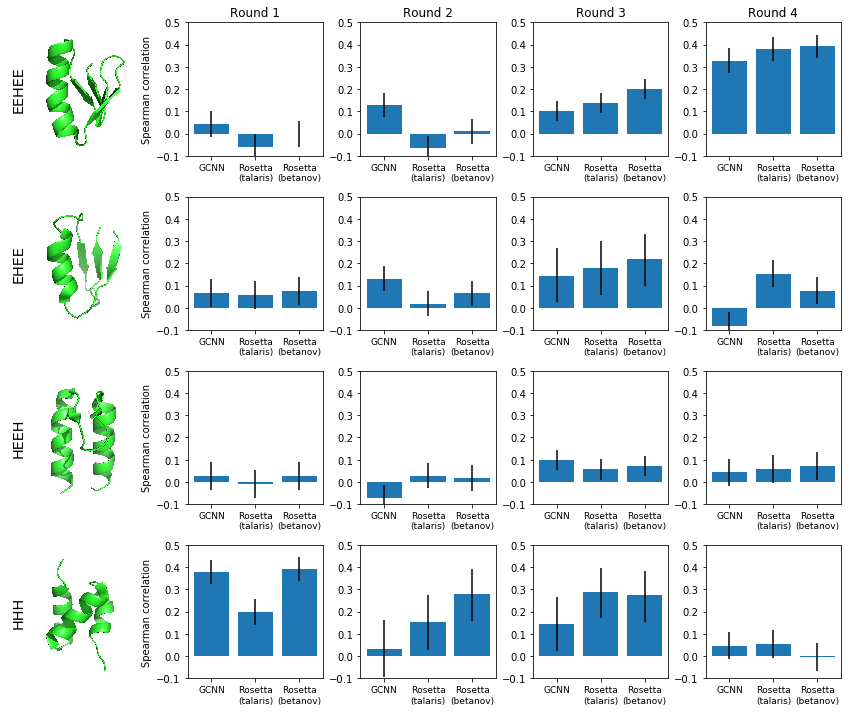

In [261]:
fg, axs = plt.subplots(4, 5, sharex=False, figsize=(12, 10))
domains = ["EEHEE", "EHEE", "HEEH", "HHH"]
for i, domain in enumerate(domains):
    for j, library in enumerate([None, "rd1", "rd2", "rd3", "rd4"]):
        ax = axs[i, j]
        if i == 0 and j > 0:
            ax.set_title(f"Round {j}")
        if j == 0:
            img = mpimg.imread(
                (
                    INPUT_PATH
                    / "global_analysis_of_protein_folding"
                    / "aan0693_designed-PDB-files"
                    / "nmr"
                    / f"{domain}.png"
                ).as_posix()
            )
            ax.imshow(img)
            ax.axis("off")
            ax.set_xlim(500, 3500)
            ax.set_ylim(4250, -400)
            ax.text(
                -0.25,
                0.5,
                domain,
                rotation=90,
                fontsize="x-large",
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes,
            )
        else:
            df = results_df[(results_df["domain"] == domain) & (results_df["library"] == library)]
            data = df["corr"].values
            data = [data[0]] + (-data[1:]).tolist()
            ax.bar([1, 2, 3], data, yerr=df[["corr_conf_upper", "corr_conf_lower"]].values.T)
            ax.set_ylim(-0.1, 0.5)
            ax.set_xticks([1, 2, 3])
            if j == 1:
                ax.set_ylabel("Spearman correlation")
            ax.set_xticklabels(["GCNN", "Rosetta\n(talaris)", "Rosetta\n(betanov)"], fontsize=9)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_designs.svg"), dpi=2000)
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_designs.pdf"), dpi=2000)
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_designs.png"), dpi=2000)

In [195]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].isnull())
        & ((stability_scores[library_name]["talaris2013_score"].notnull()))
    ]
    print(library_name, len(df))

rd1 105
rd2 229
rd3 0
rd4 0


In [196]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].notnull())
        & ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

rd1 0
rd2 0
rd3 0
rd4 1552


In [197]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

rd1 0
rd2 0
rd3 41
rd4 6495
